In [1]:
import pandas as pd
import numpy as np
import pandasql as ps
import time 
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
import math

### Read Cleaned Dataset

In [2]:
df_pa = pd.read_csv('Result_Weekly/pa_merged_align.csv')
df_user = pd.read_csv('Raw Data/users.csv') 

In [3]:
#merging user groups
#0: baseline 1:control 2:simutaneous 3:sequential

#all participants
id_list = []
for i in range(df_user.shape[0]):
    #extract users' name starting with 'mbc2'
    if (df_user['username'][i][0:4] == 'mbc2'):
        id_list.append(df_user['user_id'][i])
id_list.sort()

In [4]:
group_list = []
for user_id in id_list:
    group_list.append(df_user[df_user['user_id'] == user_id]['cond'].values[0])

In [5]:
df_user_info = pd.DataFrame(list(zip(id_list, group_list)), columns =['user_id', 'group']) 

### Outlier Removal

In [6]:
def getIQR(df, column):
    l = list(df[column])
    q1 = np.percentile(l, 25)  
    q3 = np.percentile(l, 75)
    IQR = q3-q1
    low = q1 - 1.5*IQR
    high = q3+1.5*IQR
    return [low, high]

In [7]:
# create labels for outliers
df_pa['outlier']= [1 if x>getIQR(df_pa, 'upload_min')[1] or x<getIQR(df_pa, 'upload_min')[0] else 0 for x in df_pa['upload_min']] 

In [8]:
df_pa.head(5)

,user_id,upload_time,upload_min,upload_week,outlier
0,1,2012-09-06,20.0,2,0
1,1,2012-09-07,22.0,2,0
2,1,2012-09-10,20.0,2,0
3,1,2012-09-12,20.0,3,0
4,1,2012-09-16,24.0,3,0


In [9]:
# get cleaned combined MVPA outcome (outlier removed)
df_pa_clean = df_pa[df_pa['outlier'] == 0]
df_pa_clean.head(5)

,user_id,upload_time,upload_min,upload_week,outlier
0,1,2012-09-06,20.0,2,0
1,1,2012-09-07,22.0,2,0
2,1,2012-09-10,20.0,2,0
3,1,2012-09-12,20.0,3,0
4,1,2012-09-16,24.0,3,0


In [10]:
# aggregate by week
#weekly
df_weekly = ps.sqldf('select user_id, upload_week, avg(upload_min) as PA_Min_AVG from df_pa_clean group by user_id, upload_week')
df_weekly['PA_Min_AVG'] = df_weekly['PA_Min_AVG']*7 #multiply by user by week to get weekly estimate
df_weekly.head(5)

,user_id,upload_week,PA_Min_AVG
0,1,0,14.00
1,1,2,141.75
2,1,3,120.75
3,1,4,140.00
4,1,5,282.00


### Definition: Slope/Trend

In [13]:
df_weekly.head(5)

,user_id,upload_week,PA_Min_AVG
0,1,0,14.00
1,1,2,141.75
2,1,3,120.75
3,1,4,140.00
4,1,5,282.00


In [14]:
len(df_weekly['user_id'].unique())

199

In [58]:
# refine user's upload week to contain either week 12/13/14 (month 3)
df_0 = df_weekly[df_weekly['upload_week'] == 12]
df_1 = df_weekly[df_weekly['upload_week'] == 13]
df_2 = df_weekly[df_weekly['upload_week'] == 14]

# refine user's upload week to contain either week 38/39/40 (month 9)
df_12 = df_weekly[df_weekly['upload_week'] == 38]
df_13 = df_weekly[df_weekly['upload_week'] == 39]
df_14 = df_weekly[df_weekly['upload_week'] == 40]

id_list1 = set(list(df_0['user_id']) + list(df_1['user_id']) + list(df_2['user_id']))
id_list2 = set(list(df_12['user_id']) + list(df_13['user_id']) + list(df_14['user_id']))

               
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

id_list = intersection(id_list1,id_list2)
print('Total number of participants that have records at month 3 and 9 is:', str(len(id_list)))

Total number of participants that have records at month 3 and 9 is: 124


#### Split by Groups

In [59]:
id_list_1 = intersection(id_list, list(df_user_info[df_user_info['group']==1]['user_id']))
id_list_2 = intersection(id_list, list(df_user_info[df_user_info['group']==2]['user_id']))
id_list_3 = intersection(id_list, list(df_user_info[df_user_info['group']==3]['user_id']))

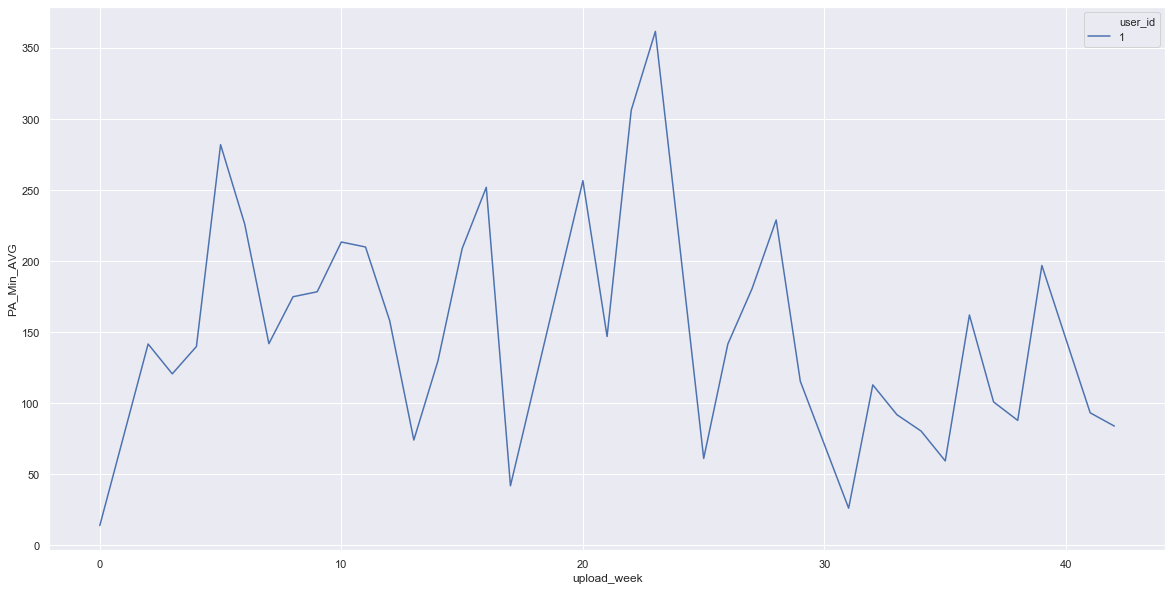

In [62]:
#one user's cases (userID == 1)
plt.figure(figsize=(20,10))
ax = sns.lineplot(x="upload_week", y="PA_Min_AVG", hue="user_id", data=df_weekly[df_weekly['user_id']==1])

In [63]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def getSlope(id_list):
    slope1 = []
    slope2 = []
    ids = []
    # set up break point at week 13
    for user_id in id_list:
        user1 = df_weekly[df_weekly['user_id'] == user_id]
        try:
            index = list(user1['upload_week']).index(13)
        except ValueError:
            #print('Week 13 could not be found, using week 12/14 istead')
            if 12.in(list(user1['upload_week'])):
                index = list(user1['upload_week']).index(12)
            elif 14.in(list(user1['upload_week'])):
                index =list(user1['upload_week']).index(14)
            else:
                print('Attention Needed')

        # break up into two periods
        #intervention = user1[:index]
        follow_up = user1[index:]

        # split into train/test
        #print('id:', user_id )
        ids.append(user_id)
        #X1 = intervention['upload_week'].values.reshape(-1,1)
        #y1 = intervention["PA_Min_AVG"].values.reshape(-1,1)
        X2 = follow_up['upload_week'].values.reshape(-1,1)
        y2 = follow_up["PA_Min_AVG"].values.reshape(-1,1)  

        # build linear regression models
        #regressor1 = LinearRegression()  
        #regressor1.fit(X1, y1) #training the algorithm
        #y_pred1 = regressor1.predict(X1)

        regressor2 = LinearRegression()  
        regressor2.fit(X2, y2) #training the algorithm
        y_pred2 = regressor2.predict(X2)

        #To retrieve the intercept:
        #slope1.append(regressor1.coef_[0][0])
        slope2.append(regressor2.coef_[0][0])
    return slope2

In [64]:
def getIQR(l):
    q1 = np.percentile(l, 25)  
    q3 = np.percentile(l, 75)
    IQR = q3-q1
    low = q1 - 1.5*IQR
    high = q3+1.5*IQR
    return [low, high]

In [65]:
slope_group_1 = getSlope(id_list_1)
low, high = getIQR(slope_group_1)
slope_group_1 = [num for num in slope_group_1 if num >= low and num <= high]
len(slope_group_1)

9

In [66]:
slope_group_2 = getSlope(id_list_2)
low, high = getIQR(slope_group_2)
slope_group_2 = [num for num in slope_group_2 if num >= low and num <= high]
len(slope_group_2)

54

In [67]:
slope_group_3 = getSlope(id_list_3)
low, high = getIQR(slope_group_3)
slope_group_3 = [num for num in slope_group_3 if num >= low and num <= high]
len(slope_group_3)

56

### Slope by Positive and Negative

In [68]:
def slopeResult1(slope):
    countPos = 0
    for i in slope:
        if(i >= 0):
            countPos = countPos + 1
    return([len(slope), countPos, len(slope) - countPos, round(countPos/len(slope)*100, 2)])

In [69]:
slopeR1 = slopeResult1(slope_group_1)
slopeR2 = slopeResult1(slope_group_2)
slopeR3 = slopeResult1(slope_group_3)

In [70]:
group1 = ['Control'] + slopeR1
group2 = ['Simultaneous'] + slopeR2
group3 = ['Sequential'] + slopeR3

pd.DataFrame([group2, group3, group1], columns=['Group', 'Total', 'Maintained','Non-maintained', 'Percentage'])

,Group,Total,Maintained,Non-maintained,Percentage
0,Simultaneous,54,21,33,38.89
1,Sequential,56,29,27,51.79
2,Control,9,4,5,44.44


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


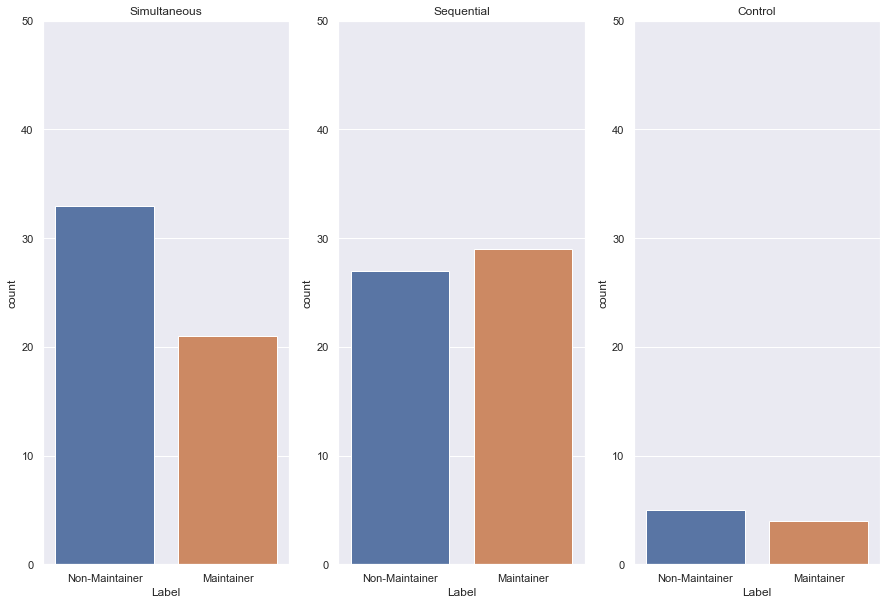

In [81]:
#create labels 
df_month3_group1 = pd.DataFrame(['Maintainer'] * group1[2] + ['Non-Maintainer'] * group1[3], columns = ['Label'])
df_month3_group2 = pd.DataFrame(['Maintainer'] * group2[2] + ['Non-Maintainer'] * group2[3], columns = ['Label'])
df_month3_group3 = pd.DataFrame(['Maintainer'] * group3[2] + ['Non-Maintainer'] * group3[3], columns = ['Label'])

#visualize
fig, ax =plt.subplots(1,3)
ax1, ax2, ax3 = ax.ravel()
ax1 = sns.countplot(df_month3_group2['Label'], ax=ax[0], order=['Non-Maintainer','Maintainer'])
ax2 = sns.countplot(df_month3_group3['Label'], ax=ax[1], order=['Non-Maintainer','Maintainer'])
ax3 = sns.countplot(df_month3_group1['Label'], ax=ax[2], order=['Non-Maintainer','Maintainer'])
ax1.set_ylim([0, 50])
ax1.set_title("Simultaneous")
ax2.set_ylim([0, 50])
ax2.set_title("Sequential")
ax3.set_ylim([0, 50])
ax3.set_title("Control")


fig.show()

### K-Means Cluster for Slopes

In [88]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

def Kmeans(K, slope):
    X = np.array(slope).reshape(-1, 1)
    kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
    result_labels = kmeans.labels_
    print(kmeans.cluster_centers_)
    print('Number of cluster:', K, 'score:', silhouette_score(X, result_labels))
    print('-----------------------------------------------------------------------')
    num = []
    for i in range(K):
        print('Label:', i, list(result_labels).count(i)/len(result_labels)*100)
        print('Label:', i, list(result_labels).count(i))
        num.append(list(result_labels).count(i))
    return X, result_labels, num

In [91]:
X, result_labels, num1 = Kmeans(2, slope_group_1)

[[ 1.98924304]
 [-1.24242083]]
Number of cluster: 2 score: 0.7037697249317213
-----------------------------------------------------------------------
Label: 0 33.33333333333333
Label: 0 3
Label: 1 66.66666666666666
Label: 1 6


In [92]:
X, result_labels, num2 = Kmeans(2, slope_group_2)

[[-1.77967998]
 [ 4.83190112]]
Number of cluster: 2 score: 0.6740164372942913
-----------------------------------------------------------------------
Label: 0 70.37037037037037
Label: 0 38
Label: 1 29.629629629629626
Label: 1 16


In [93]:
X, result_labels, num3 = Kmeans(2, slope_group_3)

[[-2.03495562]
 [ 4.11255669]]
Number of cluster: 2 score: 0.6263108345156831
-----------------------------------------------------------------------
Label: 0 51.78571428571429
Label: 0 29
Label: 1 48.214285714285715
Label: 1 27


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


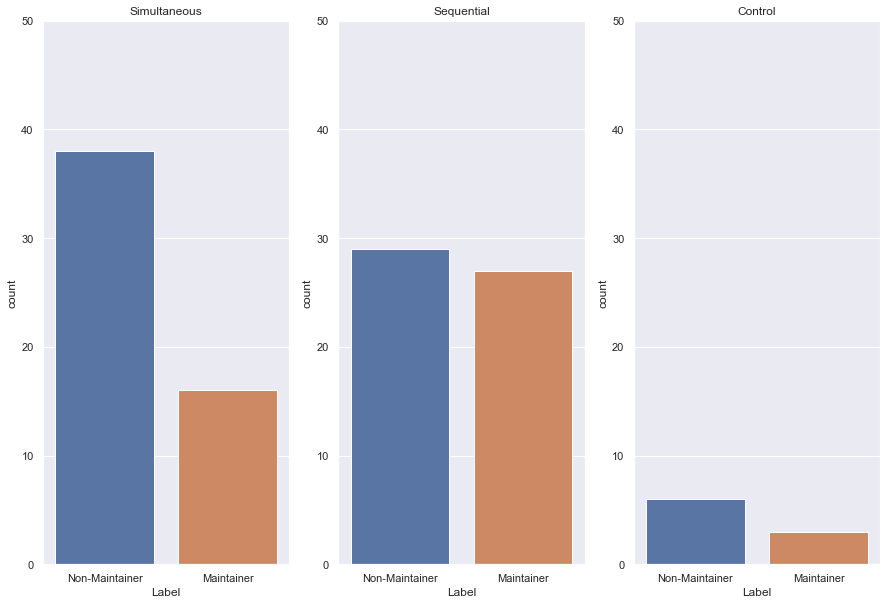

In [94]:
#visualize the result

#create labels 
df_month3_group1 = pd.DataFrame(['Maintainer'] * num1[0] + ['Non-Maintainer'] * num1[1], columns = ['Label'])
df_month3_group2 = pd.DataFrame(['Maintainer'] * num2[1] + ['Non-Maintainer'] * num2[0], columns = ['Label'])
df_month3_group3 = pd.DataFrame(['Maintainer'] * num3[1] + ['Non-Maintainer'] * num3[0], columns = ['Label'])

#visualize
fig, ax =plt.subplots(1,3)
ax1, ax2, ax3 = ax.ravel()
ax1 = sns.countplot(df_month3_group2['Label'], ax=ax[0], order=['Non-Maintainer','Maintainer'])
ax2 = sns.countplot(df_month3_group3['Label'], ax=ax[1], order=['Non-Maintainer','Maintainer'])
ax3 = sns.countplot(df_month3_group1['Label'], ax=ax[2], order=['Non-Maintainer','Maintainer'])
ax1.set_ylim([0, 50])
ax1.set_title("Simultaneous")
ax2.set_ylim([0, 50])
ax2.set_title("Sequential")
ax3.set_ylim([0, 50])
ax3.set_title("Control")


fig.show()

In [99]:
def getResult(m, nonm):
    Total = m + nonm
    Maintained = m
    Non_maintained = nonm
    Percentage = round(Maintained/(Maintained+Non_maintained)*100, 2)
    return([Total, Maintained,Non_maintained, Percentage])

[9, 3, 6, 33.33]

In [100]:
slopeR1 = getResult(num1[0],num1[1])
slopeR2 = getResult(num2[1],num2[0])
slopeR3 = getResult(num3[1],num3[0])

group1 = ['Control'] + slopeR1
group2 = ['Simultaneous'] + slopeR2
group3 = ['Sequential'] + slopeR3

pd.DataFrame([group2, group3, group1], columns=['Group', 'Total', 'Maintained','Non-maintained', 'Percentage'])

,Group,Total,Maintained,Non-maintained,Percentage
0,Simultaneous,54,16,38,29.63
1,Sequential,56,27,29,48.21
2,Control,9,3,6,33.33


### Visualize Clusters

In [277]:
x = list(X.ravel())

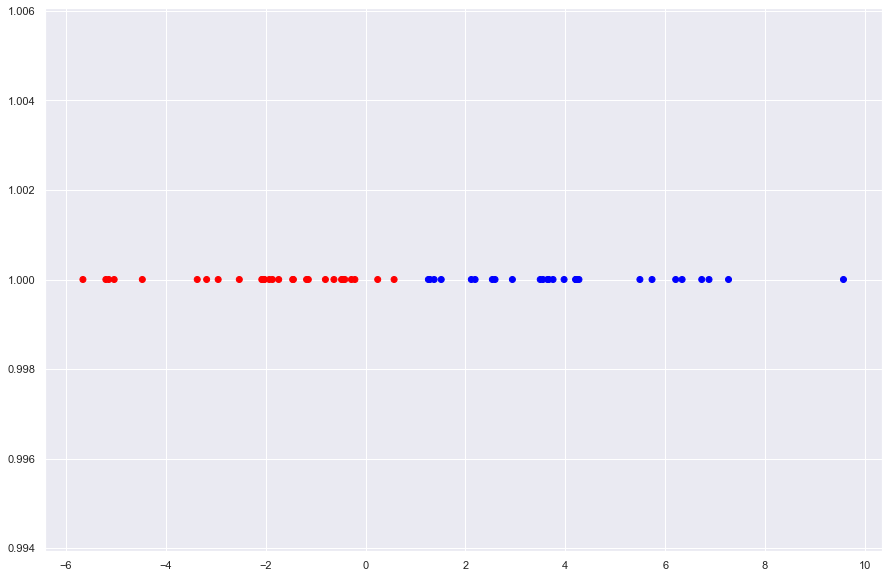

In [101]:
x = list(X.ravel())
result_labels_color = []
for i in result_labels:
    if i == 0:
        result_labels_color.append('red')
    elif i == 1:
        result_labels_color.append('blue')
    elif i == 2:
        result_labels_color.append('green')
    elif i == 3:
        result_labels_color.append('yellow')
dummyY = [1]* len(x)
plt.scatter(x, dummyY, c=result_labels_color)
plt.show()

### Agglomerative Cluster for Slopes

In [83]:
from sklearn.cluster import AgglomerativeClustering

K = 2
cluster = AgglomerativeClustering(n_clusters=K).fit(X)
result_labels = cluster.labels_
#print(cluster.cluster_centers_)
print('Number of cluster:', K, 'score:', silhouette_score(X, result_labels))
print('-----------------------------------------------------------------------')
for i in range(K):
    print('Label:', i, list(result_labels).count(i)/len(result_labels)*100)
    print('Label:', i, list(result_labels).count(i))

Number of cluster: 2 score: 0.6635824851586628
-----------------------------------------------------------------------
Label: 0 68.65671641791045
Label: 0 46
Label: 1 31.343283582089555
Label: 1 21


In [78]:
cluster.labels_

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0], dtype=int64)

### Hierarchical Cluster

In [84]:
import scipy.cluster.hierarchy as sch

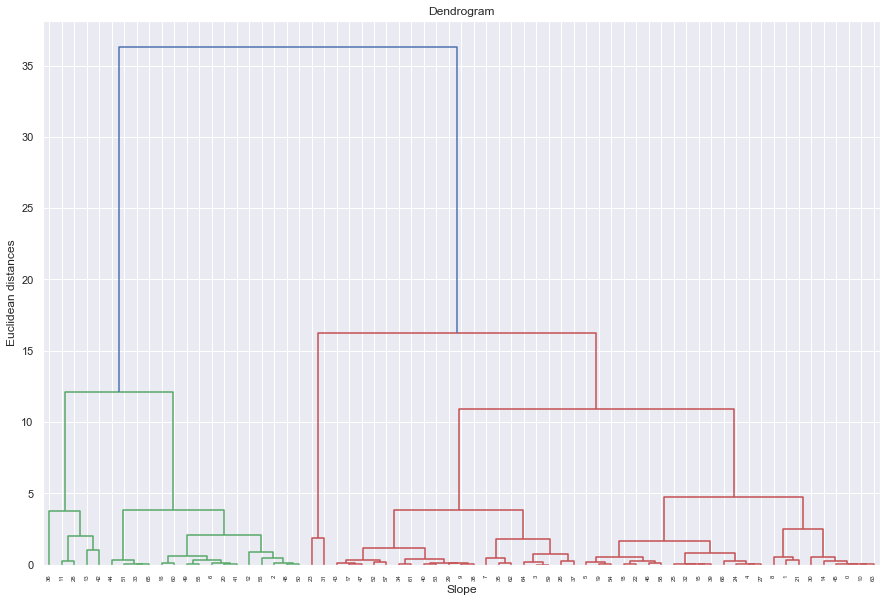

In [86]:
dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Slope')
plt.ylabel('Euclidean distances')
plt.show()

## Maintenance Definition (Traditional (lax criterion)): 
#### MVPA from intervention (3 month) and end of follow-up (9 month)
#### If participants reached 150 MVPA level

In [16]:
# refine user's upload week to contain either week 12/13/14 (month 3)
df_0 = df_weekly[df_weekly['upload_week'] == 12]
df_1 = df_weekly[df_weekly['upload_week'] == 13]
df_2 = df_weekly[df_weekly['upload_week'] == 14]

# refine user's upload week to contain either week 38/39/40 (month 9)
df_12 = df_weekly[df_weekly['upload_week'] == 38]
df_13 = df_weekly[df_weekly['upload_week'] == 39]
df_14 = df_weekly[df_weekly['upload_week'] == 40]

id_list1 = set(list(df_0['user_id']) + list(df_1['user_id']) + list(df_2['user_id']))
id_list2 = set(list(df_12['user_id']) + list(df_13['user_id']) + list(df_14['user_id']))

               
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

id_list = intersection(id_list1,id_list2)
print('Total number of participants that have records at month 3 and 9 is:', str(len(id_list)))

Total number of participants that have records at month 3 and 9 is: 124


In [17]:
users_before = list(set(list(df_weekly['user_id'])))
users_after = id_list
users_raw = list(set(list(df_pa['user_id'])))

In [21]:
#0: baseline 1:control 2:simutaneous 3:sequential
user_group_before = {
    1:0,
    2:0,
    3:0
}

user_group_after = {
    1:0,
    2:0,
    3:0
}

for ids in users_before:
    group = df_user_info[df_user_info['user_id'] == ids]['group'].values[0]
    user_group_before[group] = user_group_before[group] + 1

for ids in users_after:
    group = df_user_info[df_user_info['user_id'] == ids]['group'].values[0]
    user_group_after[group] = user_group_after[group] + 1

In [22]:
user_group_before

{1: 33, 2: 83, 3: 83}

In [23]:
user_group_after

{1: 11, 2: 55, 3: 58}

#### Get valid users from 3 groups 

In [24]:
month3 = [12,13,14]
month9 = [38,39,40]

In [25]:
df_valid = df_weekly[df_weekly['user_id'].isin(users_after)]
df_month3 = df_valid[df_valid['upload_week'].isin(month3)]
df_month9 = df_valid[df_valid['upload_week'].isin(month9)]

In [26]:
len(set(df_valid['user_id']))

124

In [27]:
#get three weeks' average at month 3 and 9
df_month3_avg = ps.sqldf("select user_id, AVG(PA_Min_AVG) as MVPA_avg from df_month3 group by user_id")
df_month9_avg = ps.sqldf("select user_id, AVG(PA_Min_AVG) as MVPA_avg from df_month9 group by user_id")

#append groups 
df_month3_avg = pd.merge(df_month3_avg, df_user_info, how='left', on=['user_id'])
df_month9_avg = pd.merge(df_month9_avg, df_user_info, how='left', on=['user_id'])

In [36]:
def showAll(df_month3_avg):
    #get groups
    df_month3_group1 = df_month3_avg[df_month3_avg['group'] == 1]
    df_month3_group2 = df_month3_avg[df_month3_avg['group'] == 2]
    df_month3_group3 = df_month3_avg[df_month3_avg['group'] == 3]
    
    #create labels 
    df_month3_group1['Label'] = ['Non-Maintainer' if x < 150 else 'Maintainer' for x in df_month3_group1['MVPA_avg']]
    df_month3_group2['Label'] = ['Non-Maintainer' if x < 150 else 'Maintainer' for x in df_month3_group2['MVPA_avg']]
    df_month3_group3['Label'] = ['Non-Maintainer' if x < 150 else 'Maintainer' for x in df_month3_group3['MVPA_avg']]
    
    #visualize
    fig, ax =plt.subplots(1,3)
    ax1, ax2, ax3 = ax.ravel()
    ax1 = sns.countplot(df_month3_group2['Label'], ax=ax[0], order=['Non-Maintainer','Maintainer'])
    ax2 = sns.countplot(df_month3_group3['Label'], ax=ax[1], order=['Non-Maintainer','Maintainer'])
    ax3 = sns.countplot(df_month3_group1['Label'], ax=ax[2], order=['Non-Maintainer','Maintainer'])
    ax1.set_ylim([0, 50])
    ax1.set_title("Simultaneous")
    ax2.set_ylim([0, 50])
    ax2.set_title("Sequential")
    ax3.set_ylim([0, 50])
    ax3.set_title("Control")
    
    
    fig.show()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

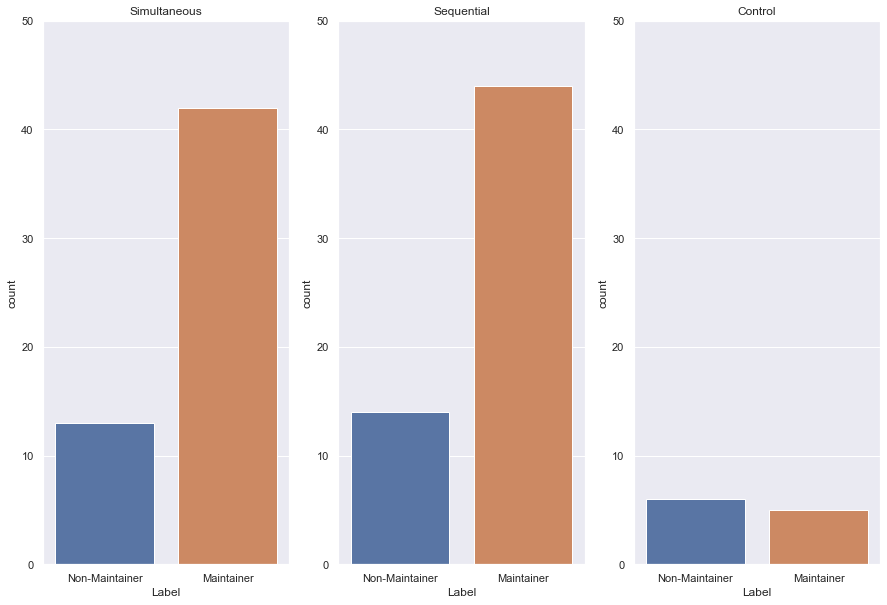

In [37]:
showAll(df_month9_avg)

In [38]:
###Number of Maintainers
def get_M_number(df_month3_avg):
    df_month3_group1 = df_month3_avg[df_month3_avg['group'] == 1]
    df_month3_group2 = df_month3_avg[df_month3_avg['group'] == 2]
    df_month3_group3 = df_month3_avg[df_month3_avg['group'] == 3]
    
    #get number of maintained vs non-maintained
    m1 = len(df_month3_group1[df_month3_group1['MVPA_avg']>=150])
    nm1 = len(df_month3_group1[df_month3_group1['MVPA_avg']<150])
    p1 = round(m1 / (m1+nm1) * 100, 2)
    m2 = len(df_month3_group2[df_month3_group2['MVPA_avg']>=150])
    nm2 = len(df_month3_group2[df_month3_group2['MVPA_avg']<150])
    p2 = round(m2 / (m2+nm2) * 100, 2)
    m3 = len(df_month3_group3[df_month3_group3['MVPA_avg']>=150])
    nm3 = len(df_month3_group3[df_month3_group3['MVPA_avg']<150])
    p3 = round(m3 / (m3+nm3) * 100, 2)
    
    group1 = ['Control'] + [m1, nm1, p1]
    group2 = ['Simultaneous'] + [m2, nm2, p2]
    group3 = ['Sequential'] + [m3, nm3, p3]
    
    return(pd.DataFrame([group2, group3, group1], columns=['Group','Maintained','Non-maintained', 'Percentage']))

In [40]:
get_M_number(df_month9_avg)

,Group,Maintained,Non-maintained,Percentage
0,Simultaneous,42,13,76.36
1,Sequential,44,14,75.86
2,Control,5,6,45.45


### Statistical Results

In [43]:
def Stats(df, column):
    l = list(df[column])
    for i in range(0, len(l)): 
        l[i] = float(l[i])
    Max = np.max(l)
    Min = np.min(l)
    Mean = np.mean(l)
    Median = np.median(l)
    STD = np.std(l)
    
    #outlier percentage
    q1 = np.percentile(l, 25)  
    q3 = np.percentile(l, 75)
    IQR = q3-q1
    low = q1 - 1.5*IQR
    high = q3+1.5*IQR
    outlierNum = len([i for i in l if i < low or i > high])
    outliersPercent = len([i for i in l if i < low or i > high]) / len(l) * 100
    return([Min, Max, Mean, Median, STD, outlierNum, outliersPercent])

In [44]:
def getStats(df_month3_avg):
    df_month3_group1 = df_month3_avg[df_month3_avg['group'] == 1]
    df_month3_group2 = df_month3_avg[df_month3_avg['group'] == 2]
    df_month3_group3 = df_month3_avg[df_month3_avg['group'] == 3]
    group1_Stats = ['Control'] + [df_month3_group1.shape[0]] + Stats(df_month3_group1, 'MVPA_avg')
    group2_Stats = ['Simultaneous'] + [df_month3_group2.shape[0]] + Stats(df_month3_group2, 'MVPA_avg')
    group3_Stats = ['Sequential'] + [df_month3_group3.shape[0]] + Stats(df_month3_group3, 'MVPA_avg')
    allList = [group1_Stats,group2_Stats,group3_Stats]
    return(pd.DataFrame(allList, columns=['Group', 'Participant Number','Min', 'Max', 'Mean', 'Median', 'Standard Deviation', 'Outlier Number', 'Outlier Percentage (IQR)']))

In [45]:
getStats(df_month3_avg)

,Group,Participant Number,Min,Max,Mean,Median,Standard Deviation,Outlier Number,Outlier Percentage (IQR)
0,Control,11,9.333333,579.250000,155.792424,114.916667,150.566822,1,9.090909
1,Simultaneous,55,52.500000,586.555556,266.327626,248.500000,113.795727,1,1.818182
2,Sequential,58,23.333333,497.388889,225.654310,199.722222,96.344920,1,1.724138


In [46]:
getStats(df_month9_avg)

,Group,Participant Number,Min,Max,Mean,Median,Standard Deviation,Outlier Number,Outlier Percentage (IQR)
0,Control,11,14.00,374.500,150.765152,105.000000,106.156283,0,0.000000
1,Simultaneous,55,78.05,670.250,251.148182,213.888889,139.374806,4,7.272727
2,Sequential,58,52.50,501.375,232.316379,210.000000,110.953931,0,0.000000


## Maintenance Definition (Public Health Guideline): 
#### MVPA from intervention (3 month) and end of follow-up (9 month)
#### If participants shows less than 10% decrease in MVPA

In [48]:
df_month3_avg

,user_id,MVPA_avg,group
0,1,120.800000,2
1,7,110.444444,3
2,9,291.555556,2
3,13,248.500000,2
4,14,52.500000,2
...,...,...,...
119,553,174.333333,2
120,568,169.777778,2
121,569,382.250000,3
122,583,189.777778,2


In [49]:
df_month9_avg.shape

(124, 3)

In [50]:
#combine month 3 and 9
df_month_39 = ps.sqldf('select d1.user_id as user_id, d1.MVPA_avg as MVPA_Month3, d2.MVPA_avg as MVPA_Month9 from df_month3_avg as d1 INNER JOIN df_month9_avg as d2 ON d1.user_id = d2.user_id')

#append groups
df_month_39 = pd.merge(df_month_39, df_user_info, how='left', on=['user_id'])

In [51]:
def tenPercent(row):
    if (row['MVPA_Month9'] >= (row['MVPA_Month3']*0.9)):
        val = 'Maintainer'
    else:
        val = 'Non-Maintainer'
    return val

df_month_39['Label'] = df_month_39.apply(tenPercent, axis=1)

In [52]:
df_month_39.head(5)

,user_id,MVPA_Month3,MVPA_Month9,group,Label
0,1,120.800000,143.333333,2,Maintainer
1,7,110.444444,280.388889,3,Maintainer
2,9,291.555556,313.950000,2,Maintainer
3,13,248.500000,219.605556,2,Non-Maintainer
4,14,52.500000,105.000000,2,Maintainer


#### Visualize

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


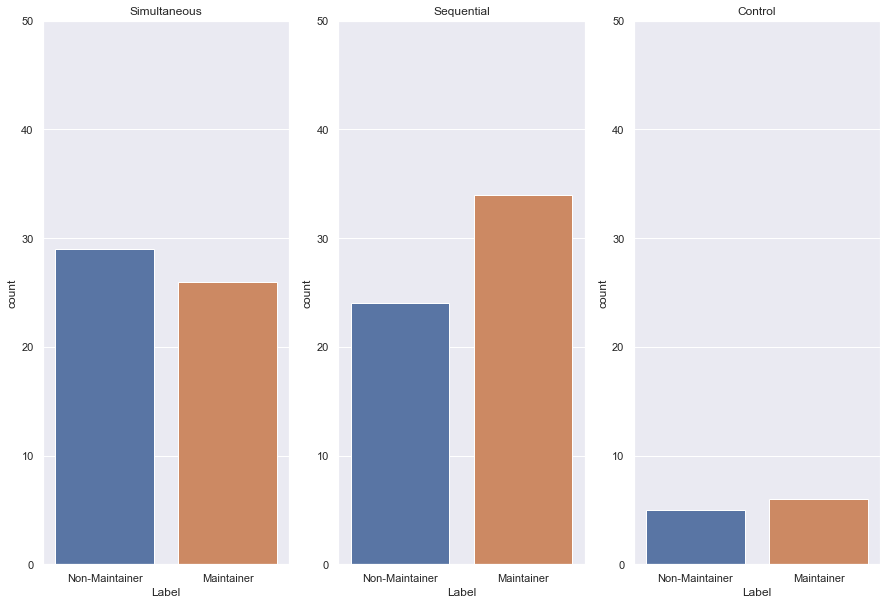

In [53]:
def showAll(df_month3_avg):
    #get groups
    df_month3_group1 = df_month3_avg[df_month3_avg['group'] == 1]
    df_month3_group2 = df_month3_avg[df_month3_avg['group'] == 2]
    df_month3_group3 = df_month3_avg[df_month3_avg['group'] == 3]
    
    #visualize
    fig, ax =plt.subplots(1,3)
    ax1, ax2, ax3 = ax.ravel()
    ax1 = sns.countplot(df_month3_group2['Label'], ax=ax[0], order=['Non-Maintainer','Maintainer'])
    ax2 = sns.countplot(df_month3_group3['Label'], ax=ax[1], order=['Non-Maintainer','Maintainer'])
    ax3 = sns.countplot(df_month3_group1['Label'], ax=ax[2], order=['Non-Maintainer','Maintainer'])
    ax1.set_ylim([0, 50])
    ax1.set_title("Simultaneous")
    ax2.set_ylim([0, 50])
    ax2.set_title("Sequential")
    ax3.set_ylim([0, 50])
    ax3.set_title("Control")
    fig.show()

showAll(df_month_39)

In [54]:
###Number of Maintainers
def get_M_number(df_month3_avg):
    df_month3_group1 = df_month3_avg[df_month3_avg['group'] == 1]
    df_month3_group2 = df_month3_avg[df_month3_avg['group'] == 2]
    df_month3_group3 = df_month3_avg[df_month3_avg['group'] == 3]
    
    #get number of maintained vs non-maintained
    m1 = len(df_month3_group1[df_month3_group1['Label'] == 'Maintainer'])
    nm1 = len(df_month3_group1[df_month3_group1['Label'] == 'Non-Maintainer'])
    p1 = round(m1 / (m1+nm1) * 100, 2)
    m2 = len(df_month3_group2[df_month3_group2['Label'] == 'Maintainer'])
    nm2 = len(df_month3_group2[df_month3_group2['Label'] == 'Non-Maintainer'])
    p2 = round(m2 / (m2+nm2) * 100, 2)
    m3 = len(df_month3_group3[df_month3_group3['Label'] == 'Maintainer'])
    nm3 = len(df_month3_group3[df_month3_group3['Label'] == 'Non-Maintainer'])
    p3 = round(m3 / (m3+nm3) * 100, 2)
    
    group1 = ['Control'] + [m1, nm1, p1]
    group2 = ['Simultaneous'] + [m2, nm2, p2]
    group3 = ['Sequential'] + [m3, nm3, p3]
    
    return(pd.DataFrame([group2, group3, group1], columns=['Group','Maintained','Non-maintained', 'Percentage']))

get_M_number(df_month_39)

,Group,Maintained,Non-maintained,Percentage
0,Simultaneous,26,29,47.27
1,Sequential,34,24,58.62
2,Control,6,5,54.55
